# Segment Anything with Annotator Demo

## Introduction:
The purpose of this Jupyter Notebook is to demonstrate __instance segmentation using a box annotator__ module for image segmentation.

Through this notebook, we aim to showcase the functionalities and capabilities of this module, empowering researchers and practitioners in the field of computer vision to leverage image segmentation techniques effectively.

### For those new to running Jupyter Notebook files:
This guide provides an overview of the basic concepts and steps involved. Jupyter Notebook is an interactive computing environment that allows you to create and share documents containing live code, visualizations, and explanatory text. The core element of a Jupyter Notebook is the cell block, which can contain either code or markdown text.

Code cells are where you write and execute your Python code. To run a code cell, you can either click the "Run" button in the toolbar, press "Shift + Enter," or select "Cell" from the menu and choose "Run Cells." When a code cell is executed, the code is sent to the Python kernel, and the output, if any, is displayed immediately below the cell.

It is essential to run the cells in order from top to bottom, as variables and functions defined in one cell can be used in subsequent cells. Notebooks also maintain the state between cells, allowing you to run and modify code iteratively.

**Note:** Please be aware that some cell blocks in this notebook may open a pop-up window for certain operations. Depending on your system and Jupyter Notebook configuration, the pop-up window might not automatically appear in the foreground. If you encounter this situation, you may need to use the Alt+Tab (or equivalent) keyboard shortcut to switch between windows and locate the pop-up window. It is recommended to keep an eye on the taskbar or window manager for any additional windows that may open during the execution of specific cell blocks. This will ensure you can access and interact with all the necessary components of the notebook effectively.

**Note:** After you are done with each pop-up window, make sure you are closing the window using the close icon on the top left of the window or hitting keyboard key "q".

## Set-up

To prepare the pipeline for execution, you need to run the setup cell. This cell performs essential setup tasks, such as importing required libraries, configuring parameters, and initializing necessary components.

Running the setup cell ensures that all the dependencies are properly imported and any required configurations are set up correctly. It establishes the foundation for the subsequent cells to run smoothly and ensures that the pipeline functions as intended.

To run the setup cell, simply click on the cell to select it and then press the "Run" button in the toolbar, or use the keyboard shortcut "Shift + Enter". Once executed, you can proceed to execute the remaining cells in the notebook to observe the desired functionalities and results of the pipeline.

It is important to execute the setup cell before running any other cells to ensure that all the necessary prerequisites are in place and the pipeline is properly initialized.

Make sure that [model checkpoint](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth) is downloaded and put it in `checkpoints` folder.

In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from model import SAM
from utils import *


# model parameters
sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
predictor = SAM()

## Loading image

When you run the cell below, it will load an image from your file system and open a separate window displaying the loaded image. You will be prompted to select your image file. Please make sure to enter the correct path and include the file extension (e.g., ".jpg", ".png", etc.).

Once the image is displayed, the subsequent cell will open another window that allows you to adjust the brightness of the loaded image interactively. You can use the provided slider to increase or decrease the brightness level according to your preference. Once you are done adjusting the brightness, you must close the image window.

This feature provides a convenient way to visualize and adjust the brightness of the image before further processing or analysis. Please note that if you proceed to the next cell without adjusting the brightness, the default brightness level will be used for subsequent operations.

**Note:** Please ensure that the images being loaded into the Jupyter notebook pipeline do not exceed a size of 1000x1000 pixels due to software and hardware limitations.

**Note:** Be aware that the pop-up window might not automatically appear in the foreground. If you encounter this situation, you may need to use the Alt+Tab (or equivalent) keyboard shortcut to switch between windows and locate the pop-up window.

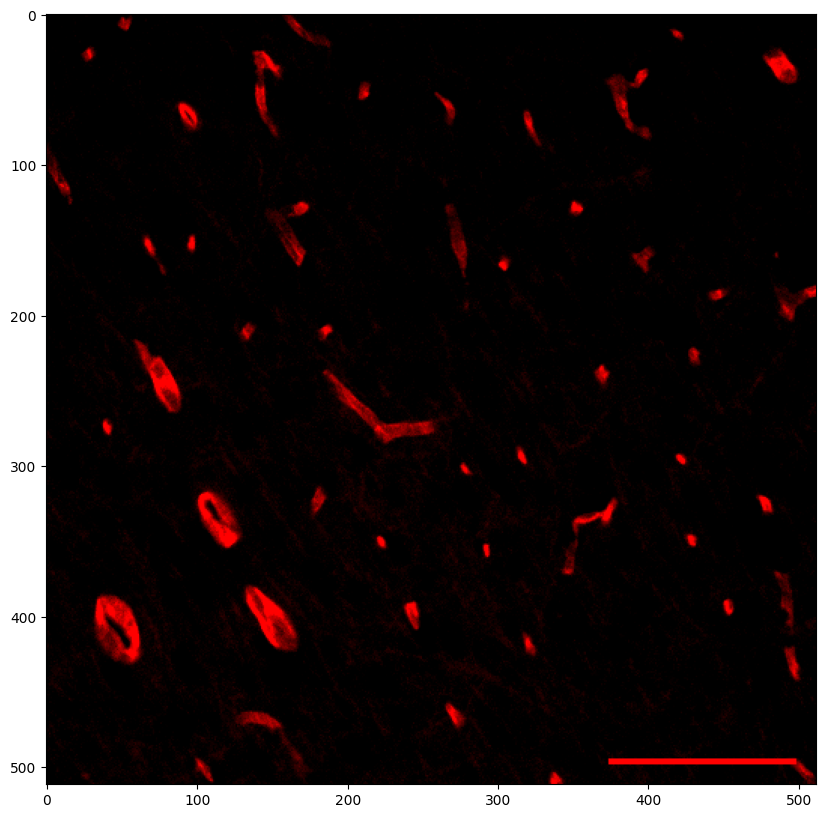

In [2]:
image_path = select_file()
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = adjust_histogram_gui(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

predictor.set_image(image)

## Instance segmentation using a box annotator

To perform instance segmentation using a box annotator tool, you can run the next cell. Instance segmentation involves identifying and delineating individual objects within an image. With the box annotator, you can draw bounding boxes around each object of interest, and the model will generate masks specifically for the objects contained within the boxes.

When you run the cell associated with this module, the annotator window will appear, allowing you to interact with the tool. To create a bounding box, simply click and hold the left mouse button at one corner of the object and drag the mouse to the opposite corner. Release the mouse button to finalize the box. You can repeat this process for each object you want to annotate.

Once you have drawn the bounding boxes, the model will automatically generate masks for the objects enclosed within the boxes. These masks provide pixel-level segmentation for each individual object, enabling you to distinguish and analyze them separately.

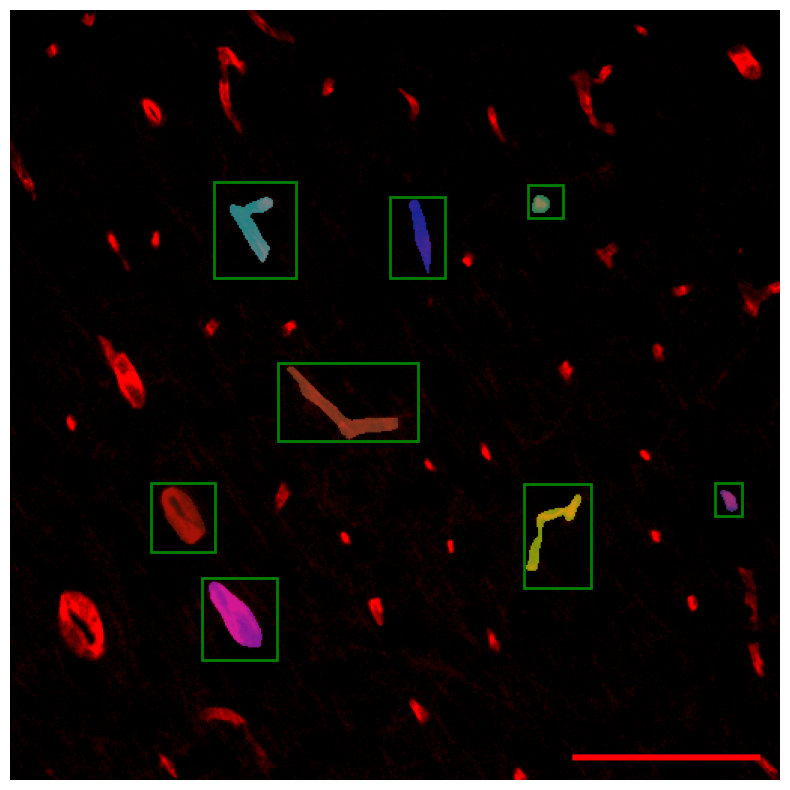

In [3]:
_, boxes, _ = annotate_image_gui(image, mode='box')
input_boxes = torch.tensor(boxes, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## Saving mask

Once you are happy with the results, you can save the mask as Numpy array with shape `[num_objs, img_height, img_width]` where each pixel in the array is represented by a Boolean value, where "True" indicates that the pixel belongs to an object, and "False" represents the background. The notebook will automatically save the file with the selected mask in the same folder as the input file. The saved file will have the same name as the original file, but with "_mask" added to the filename.

In [4]:
input_name = os.path.splitext(image_path)[0]
output_name = input_name + '_mask.npz'
np.savez_compressed(output_name, masks=masks.cpu().numpy().squeeze())

print('mask saved as: {}'.format(output_name))

mask saved as: D:/jahandar/code/sam_gui/imgs/img1_mask.npz
